In [155]:
import pandas as pd
import numpy as np
import matplotlib as plt
from mlxtend.frequent_patterns import apriori, association_rules

In [156]:
sampleData = pd.read_csv('sample3Solostove.csv')

In [157]:
sampleData.describe()

,order_id,items_total
count,5.000000e+05,500000.000000
mean,1.223516e+06,2.921776
std,6.350240e+04,1.551330
min,1.107551e+06,1.000000
25%,1.167827e+06,2.000000
50%,1.228765e+06,3.000000
75%,1.278982e+06,3.000000
max,1.329221e+06,100.000000


In [158]:
sampleData.columns

Index(['order_id', 'items_total', 'name'], dtype='object')

array([[<AxesSubplot:title={'center':'items_total'}>]], dtype=object)

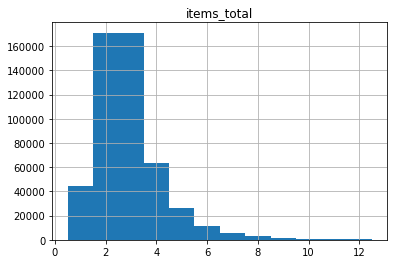

In [159]:
sampleData.hist(column = 'items_total', bins = np.arange(0,13) + 0.5)

In [160]:
numBought = sampleData['name'].value_counts()

<AxesSubplot:>

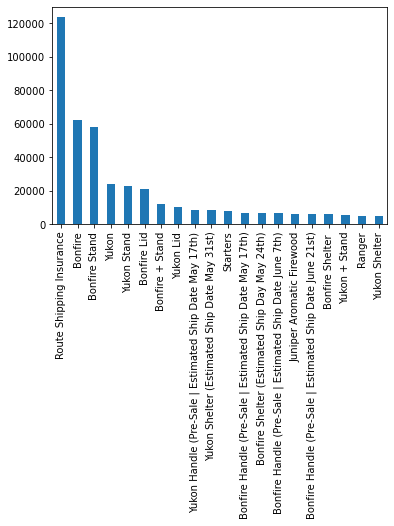

In [161]:
numBought[0:20].plot(kind='bar')

In [166]:
def find_associations(data, id_num, name, deletions):
    data['bought'] = 1
    orders = data.groupby([id_num, name])['bought'].sum().unstack().reset_index().fillna(0).set_index(id_num)
    orders = orders.drop(columns = deletions)
    def encode_units(x):
        if x <= 0:
            return False
        if x >= 1:
            return True
    orders_binary = orders.applymap(encode_units)
    frequent_itemsets = apriori(orders_binary, min_support=0.001, use_colnames=True, max_len = 2)
    frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
    rules = association_rules(frequent_itemsets, metric="lift", min_threshold=3)
    recommended = rules.groupby(['antecedents', 'consequents'])['lift'].first()
    return recommended

In [167]:
recommended = find_associations(sampleData, 'order_id', 'name', ['Route Shipping Insurance'])

In [189]:
recommended

antecedents                                    consequents                                   
(Bonfire Stand)                                (Bonfire)                                           3.150697
(Starters)                                     (Juniper Aromatic Firewood)                         7.791774
                                               (Oak Firewood)                                      8.997809
                                               (Roasting Sticks)                                   3.103791
(Pot 1800)                                     (Titan)                                           225.653445
                                                                                                    ...    
(Pot 900)                                      (Lite)                                            168.613824
(Yukon Shield (Estimated Ship Date June 7th))  (Yukon Lid)                                         3.777840
                                          